alive: 46362
dead: 8334
Proportion: 5.56 : 1


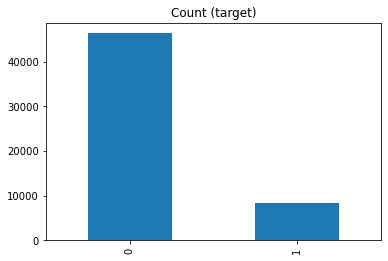

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold,cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn import metrics
from collections import defaultdict
from imblearn.pipeline import Pipeline as imbpipeline
#from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, make_scorer



df = pd.read_csv('/Volumes/Oussama/project/Data_comp/last.csv')
#df['Death'].replace({0:1, 1:0}, inplace = True)
#df_train.dropna( axis=0, how='any',thresh=20,inplace = True)
#df_train.dropna( axis=1, how='any',thresh=15000,inplace = True)
target_count = df['Death'].value_counts()
print('alive:', target_count[0])
print('dead:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [3]:
from sklearn.metrics import confusion_matrix
# Class count
count_class_0, count_class_1 = df['Death'].value_counts()

# Divide by class
df_class_0 = df[df['Death'] == 0]
df_class_1 = df[df['Death'] == 1]
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return ("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [4]:
def test_plot(acc, spec, rec, prec, resampling):
    fig = plt.figure(figsize=(3, 2.5))
    ax = fig.add_axes([0,0,1,1])
    met = ['Accuracy',  'Specificity', 'Recall','Precision']
    value = [acc, spec, rec, prec]
    barlist = ax.bar(met,value, width=0.5)
    barlist[0].set_color('royalblue')
    barlist[1].set_color('limegreen')
    barlist[2].set_color('lightcoral')
    barlist[3].set_color('olive')
    ax.set_yticks(np.arange(0, 1.25, 0.5))
    ax.set_title('Evaluation metrics for Test dataset')
    def autolabel(rects):
        for idx,rect in enumerate(barlist):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                    round(value[idx],3),
                    ha='center', va='bottom', rotation=0)

    autolabel(barlist)
    fig.savefig(resampling, facecolor='w', bbox_inches='tight')
    plt.show()

# set width of bars
barWidth = 0.15
 


def plotting(dic_acc, dic_spe, dic_rec, dic_prec, name):
    
    K = [1,3,5,9,15,25]

    metricss = ["euclidean", "manhattan", "chebyshev", "minkowski"]
    for j in metricss:
        fig, ax = plt.subplots(figsize=(9, 5))
        key_acc = [s for s in dic_acc if j in s]
        key_spe = [s for s in dic_spe if j in s]
        key_rec = [s for s in dic_rec if j in s]
        key_prec = [s for s in dic_prec if j in s]
        r1 = np.arange(len([dic_acc[s] for s in key_acc]))
        r2 = [x + 1.3 * barWidth for x in r1]
        r3 = [x + 1.3 * barWidth for x in r2]
        r4 = [x + 1.3 * barWidth for x in r3]
        # Make the plot
        rects1 = ax.bar(r1, [dic_acc[s] for s in key_acc], color='royalblue', width=barWidth, edgecolor='darkblue', label='Accuracy', align='edge')
        rects2 = ax.bar(r2, [dic_spe[s] for s in key_spe], color='limegreen', width=barWidth, edgecolor='#557f2d', label='Specificity', align='edge')
        rects3 = ax.bar(r3, [dic_rec[s] for s in key_rec], color='lightcoral', width=barWidth, edgecolor='orangered', label='Recall', align='edge')
        rects4 = ax.bar(r4, [dic_prec[s] for s in key_prec], color='olive', width=barWidth, edgecolor='darkolivegreen', label='Precision', align='edge')


        # Add xticks on the middle of the group bars
        ax.set_xlabel('Factor k', fontweight='bold')
        #ax.set_xticks([r + barWidth for r in range(len(acc))], K)
        ax.set_yticks(np.arange(0, 1.25, 0.5))
        #ax.set_yticks(np.arange(0, 1.75, 0.75))
        ax.set_xticks(r1 + 2 * barWidth)
        ax.set_xticklabels((K))



        def autolabel(rects, xpos='center'):
            """
            Attach a text label above each bar in *rects*, displaying its height.

            *xpos* indicates which side to place the text w.r.t. the center of
            the bar. It can be one of the following {'center', 'right', 'left'}.
            """

            ha = {'center': 'center', 'right': 'left', 'left': 'right'}
            offset = {'center': 0, 'right': 1, 'left': -1}

            for rect in rects:
                rect.set_linewidth(1.5)
                height = rect.get_height()
                ax.annotate('{}'.format(round(height,3)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(offset[xpos]*3, 3),  # use 3 points offset
                            textcoords="offset points",  # in both directions
                            ha=ha[xpos], va='bottom',rotation='vertical')


        autolabel(rects1, "center")
        autolabel(rects2, "center")
        autolabel(rects3, "center")
        autolabel(rects4, "center")



        # Create legend & Show graphic
        #plt.legend()
        plt.title(name+j, fontsize=15)
        ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        fig.savefig(name+j, facecolor='w', bbox_inches='tight')








In [14]:
def model_and_plot (grid_search, resampling_tech):
    
    mean_test_Precision = list(grid_search.cv_results_['mean_test_Precision'])
    mean_test_Accuracy = list(grid_search.cv_results_['mean_test_Accuracy'])
    mean_test_Recall = list(grid_search.cv_results_['mean_test_Recall'])
    mean_test_Specificity = list(grid_search.cv_results_['mean_test_Specificity'])
    
    metric_l = ['euclidean', 'euclidean', 'euclidean', 'euclidean',
                       'euclidean', 'euclidean', 'manhattan', 'manhattan',
                       'manhattan', 'manhattan', 'manhattan', 'manhattan',
                       'chebyshev', 'chebyshev', 'chebyshev', 'chebyshev',
                       'chebyshev', 'chebyshev', 'minkowski', 'minkowski',
                       'minkowski', 'minkowski', 'minkowski', 'minkowski']
    k_l = [1, 3, 5, 9, 15, 25, 1, 3, 5, 9, 15, 25, 1, 3, 5, 9, 15,
                        25, 1, 3, 5, 9, 15, 25]

    K = [1,3,5,9,15,25]

    metricss = ["euclidean", "manhattan", "chebyshev", "minkowski"]




    acc = defaultdict(dict)
    for k,v1,v2 in zip(metric_l, k_l, mean_test_Accuracy):
        acc[k +' '+ str(v1)] = v2
    acc = dict(acc)

    prec = defaultdict(dict)
    for k,v1,v2 in zip(metric_l, k_l, mean_test_Precision):
        prec[k +' '+ str(v1)] = v2
    prec = dict(prec)

    rec = defaultdict(dict)
    for k,v1,v2 in zip(metric_l, k_l, mean_test_Recall):
        rec[k +' '+ str(v1)] = v2
    rec = dict(rec)

    spec = defaultdict(dict)
    for k,v1,v2 in zip(metric_l, k_l, mean_test_Specificity):
        spec[k +' '+ str(v1)] = v2
    spec = dict(spec)
    
    
    
    plotting(acc, spec, rec, prec,resampling_tech)
    





In [5]:
def specificity_scorer(y_true, y_pred):
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

specificity = make_scorer(specificity_scorer, greater_is_better=True)

scoring_metrics = { 
        'Precision': 'precision', 
        'Accuracy': 'accuracy',
        'Recall': 'recall',
        'Specificity': specificity }



In [6]:
#teest


# Remove 'id' and 'target' columns
labels = df.columns[2:]


X = df[labels].copy()
y = df['Death'].copy()


# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X)

# Impute our data, then train
X = imp.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)
                                                    
                                                    

ClusterCentroids(random_state=0)
pipeline_SMOTE = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', KNeighborsClassifier()]])

pipeline_CC = imbpipeline(steps = [['ClusterCentroids', ClusterCentroids(random_state=11, n_jobs=-1)],
                                ['classifier', KNeighborsClassifier()]])

pipeline_boot = imbpipeline(steps = [['bootstrap', RandomOverSampler(random_state=11, shrinkage=None)],
                                ['classifier', KNeighborsClassifier()]])

pipeline_RUS = imbpipeline(steps = [['RandomUnderSampling', RandomUnderSampler(random_state=11)],
                                ['classifier', KNeighborsClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=10,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = [{'classifier__n_neighbors':[1,3,5,9,15,25],
             'classifier__metric': ["euclidean", "manhattan", "chebyshev"]},
             {'classifier__n_neighbors':[1,3,5,9,15,25],
             'classifier__metric': ["minkowski"],
             "classifier__p": [3]}]

param_grid2 = [{'n_neighbors':[1,3,5,9,15,25],
             'metric': ["euclidean", "manhattan", "chebyshev"]},
              {'n_neighbors':[1,3,5,9,15,25],
             'metric': ["minkowski"],
              "p" : [4]}]

In [7]:
grid_search_No_Res = GridSearchCV(estimator=KNeighborsClassifier(),
                           param_grid=param_grid2,
                           scoring= scoring_metrics ,
                           refit= 'Recall',
                           cv=stratified_kfold,
                           error_score="raise",
                           n_jobs=-1)


grid_search_SMOTE = GridSearchCV(estimator=pipeline_SMOTE,
                           param_grid=param_grid,
                           scoring= scoring_metrics ,
                           refit= 'Recall',
                           cv=stratified_kfold,
                           error_score="raise",
                           n_jobs=-1)

grid_search_CC = GridSearchCV(estimator=pipeline_CC,
                           param_grid=param_grid,
                           scoring= scoring_metrics,
                           refit= 'Recall',
                           cv=stratified_kfold,
                           error_score="raise",
                           n_jobs=-1)

grid_search_boot = GridSearchCV(estimator=pipeline_boot,
                           param_grid=param_grid,
                           scoring= scoring_metrics,
                           refit= 'Recall',
                           cv=stratified_kfold,
                           error_score="raise",
                           n_jobs=-1)

grid_search_RUS = GridSearchCV(estimator=pipeline_RUS,
                           param_grid=param_grid,
                           scoring= scoring_metrics,
                           refit= 'Recall',
                           cv=stratified_kfold,
                           error_score="raise",
                           n_jobs=-1)

In [8]:
start = time.time()
grid_search_No_Res.fit(X_train, y_train)
end = time.time()
timer(start,end)

'01:30:49.38'

In [9]:
#change timer function to return result instead of printing it
start = time.time()
grid_search_SMOTE.fit(X_train, y_train)
end = time.time()
time_SMOTE = timer(start,end)
time_SMOTE

'02:43:18.56'

In [12]:
start = time.time()
grid_search_CC.fit(X_train, y_train)
end = time.time()
timer(start,end)
time_CC = timer(start,end)
time_CC

/Users/oussamagharsellaoui/opt/anaconda3/lib/python3.8/site-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:120: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  warnings.warn(


'17:06:51.94'

In [11]:
start = time.time()
grid_search_boot.fit(X_train, y_train)
end = time.time()
timer(start,end)
time_boot = timer(start,end)
time_boot

'03:00:23.46'

In [10]:
start = time.time()
grid_search_RUS.fit(X_train, y_train)
end = time.time()
timer(start,end)
time_RUS = timer(start,end)
time_RUS

'00:27:52.55'

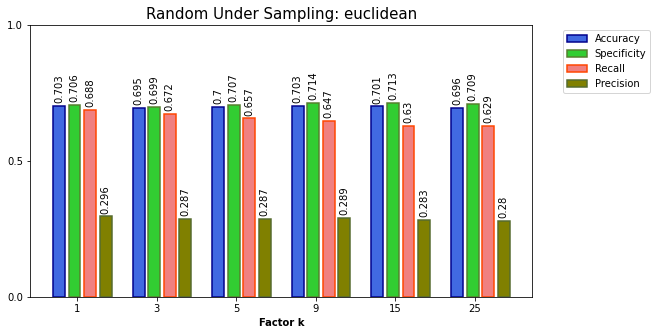

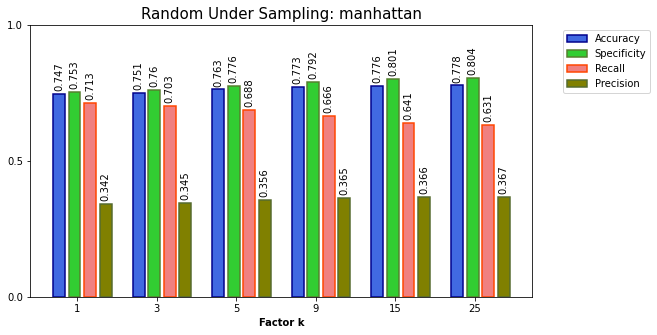

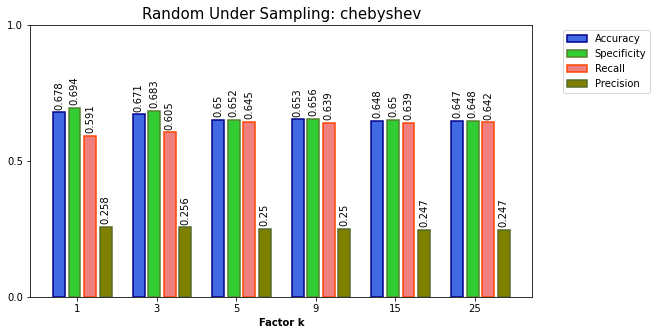

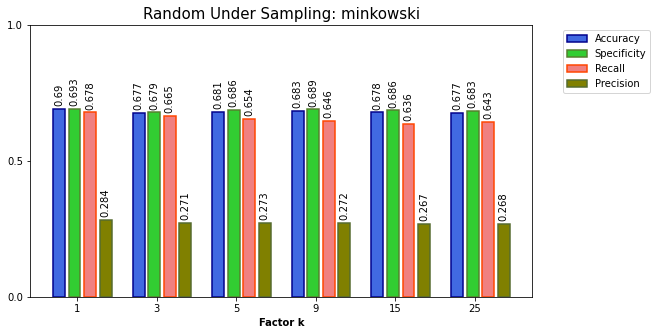

In [15]:
model_and_plot(grid_search_RUS, "Random Under Sampling: ")

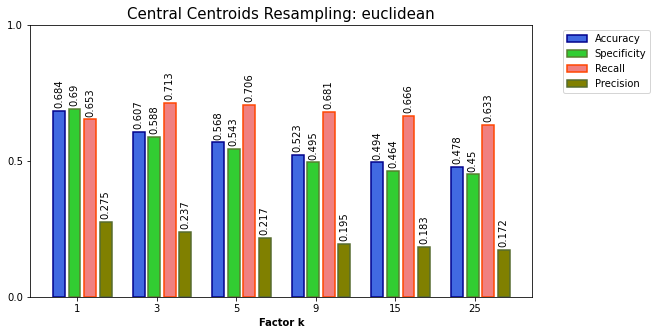

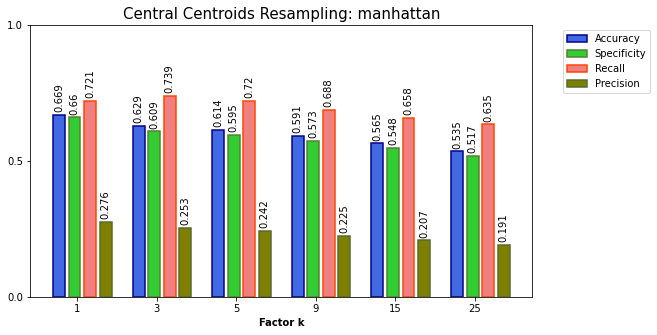

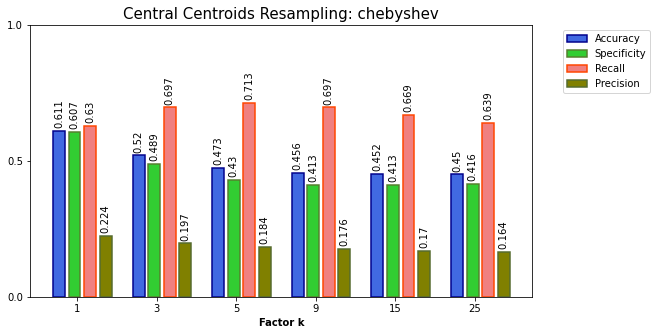

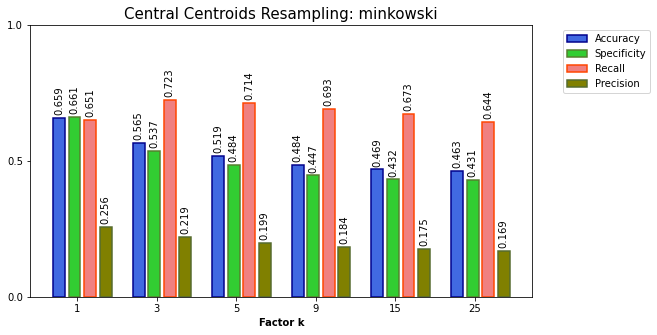

In [16]:
model_and_plot(grid_search_CC, "Central Centroids Resampling: ")

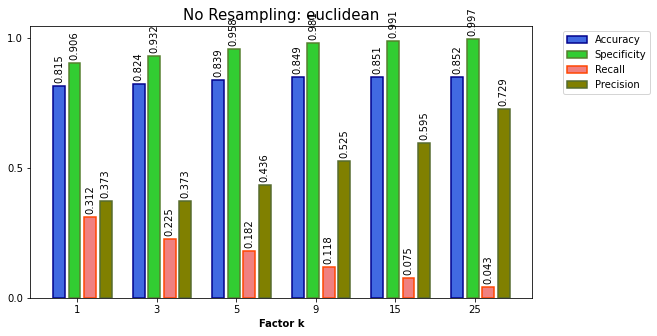

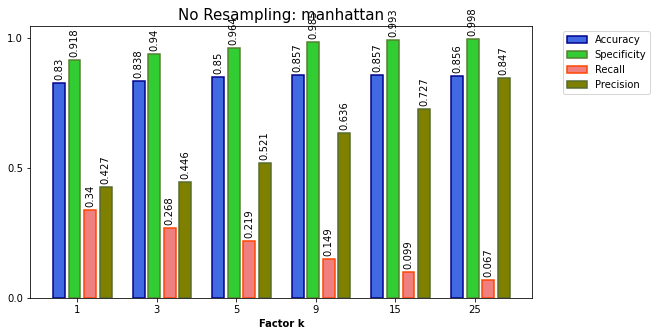

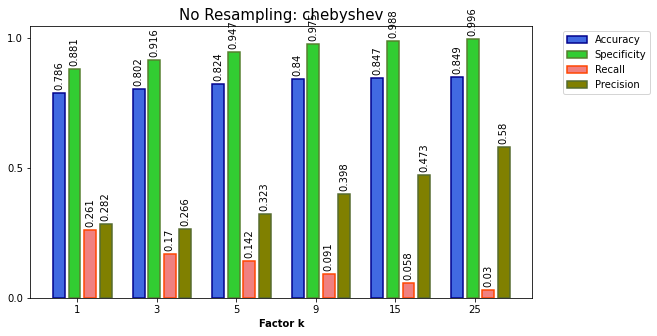

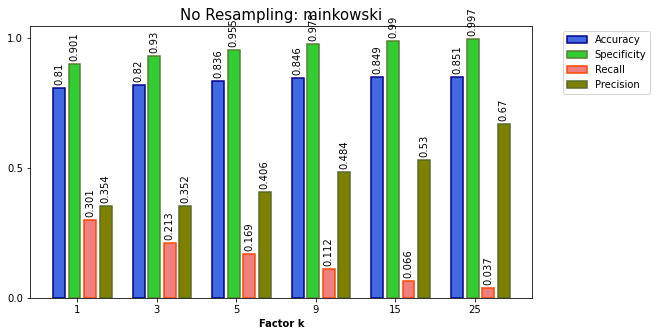

In [17]:
model_and_plot(grid_search_No_Res, "No Resampling: ")

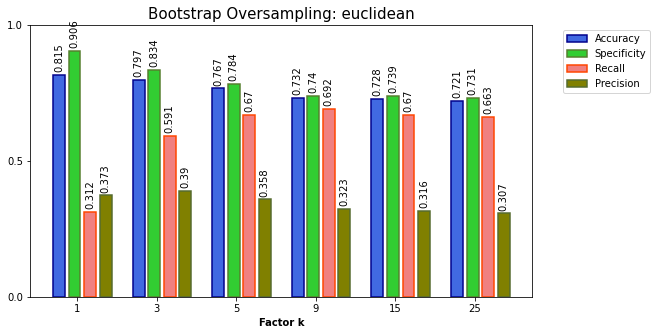

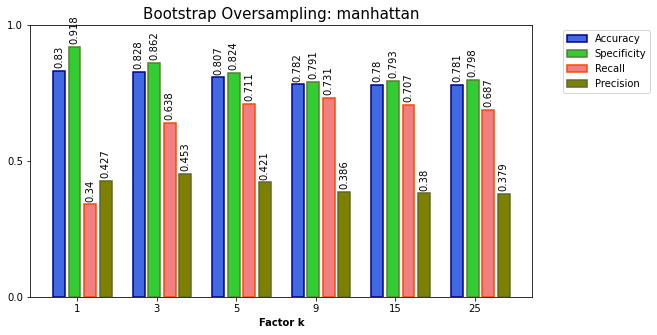

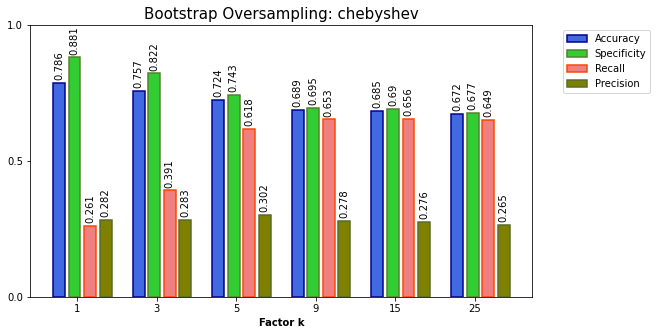

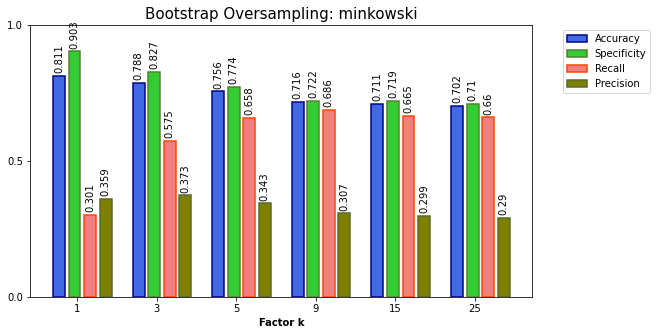

In [18]:
model_and_plot(grid_search_boot, "Bootstrap Oversampling: ")

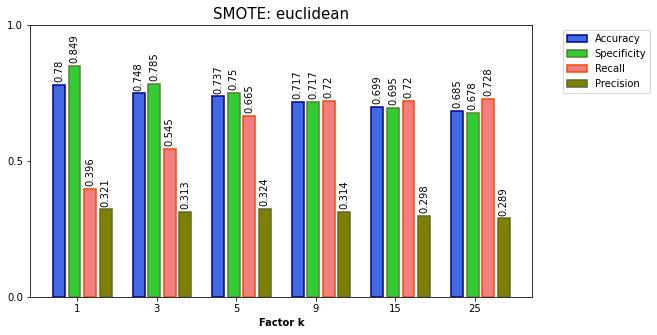

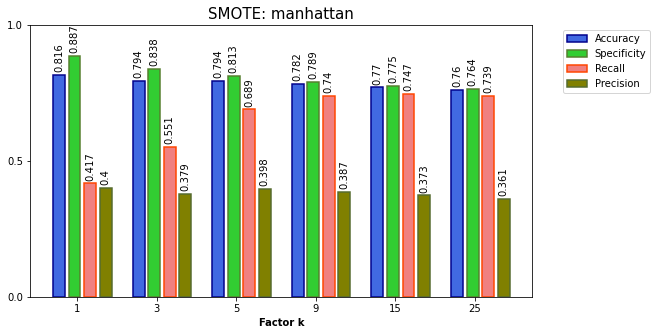

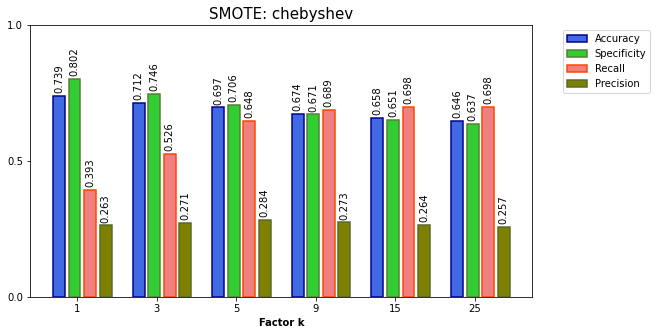

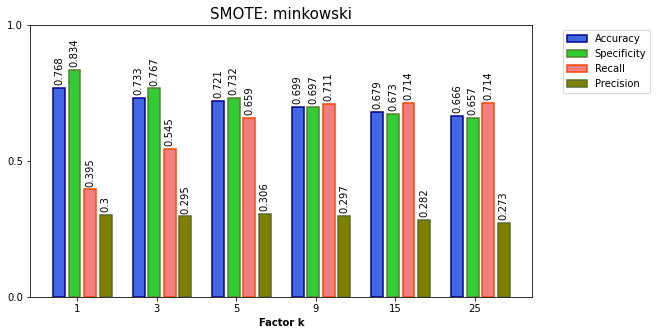

In [19]:
model_and_plot(grid_search_SMOTE, "SMOTE: ")

In [20]:
y_pred_boot = grid_search_boot.predict(X_test)

In [21]:
y_pred_SMOTE = grid_search_SMOTE.predict(X_test)

In [22]:
y_pred_CC = grid_search_CC.predict(X_test)

In [23]:
y_pred_No_Res = grid_search_No_Res.predict(X_test)

In [24]:
y_pred_RUS = grid_search_RUS.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred_boot)
pd.crosstab(y_test, y_pred_boot, rownames = ['Actual'], colnames =['Predicted'], margins = True)

In [ ]:
confusion_matrix(y_test,y_pred_SMOTE)
pd.crosstab(y_test, y_pred_SMOTE, rownames = ['Actual'], colnames =['Predicted'], margins = True)

In [ ]:
confusion_matrix(y_test,y_pred_CC)
pd.crosstab(y_test, y_pred_CC, rownames = ['Actual'], colnames =['Predicted'], margins = True)

In [ ]:
confusion_matrix(y_test,y_pred_No_Res)
pd.crosstab(y_test, y_pred_No_Res, rownames = ['Actual'], colnames =['Predicted'], margins = True)

In [ ]:
confusion_matrix(y_test,y_pred_RUS)
pd.crosstab(y_test, y_pred_RUS, rownames = ['Actual'], colnames =['Predicted'], margins = True)

In [ ]:
print('Accuracy:', accuracy_score(y_test,y_pred_No_Res),'\nRecall:', recall_score(y_test,y_pred_No_Res),
     '\nPrecision:', precision_score(y_test,y_pred_No_Res),'\nSpecificity:', specificity_scorer(y_test,y_pred_No_Res))

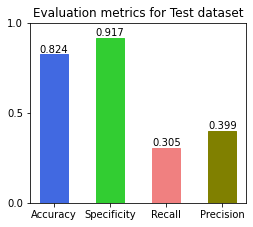

In [25]:

test_plot(accuracy_score(y_test,y_pred_No_Res),specificity_scorer(y_test,y_pred_No_Res),recall_score(y_test,y_pred_No_Res),precision_score(y_test,y_pred_No_Res), 'No_resampling')

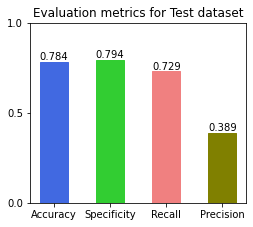

In [26]:
test_plot(accuracy_score(y_test,y_pred_boot),specificity_scorer(y_test,y_pred_boot),recall_score(y_test,y_pred_boot),precision_score(y_test,y_pred_boot), 'bootstrap')

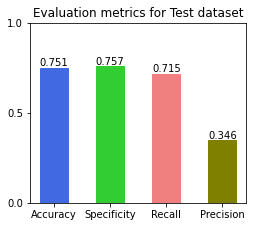

In [27]:
test_plot(accuracy_score(y_test,y_pred_RUS),specificity_scorer(y_test,y_pred_RUS),recall_score(y_test,y_pred_RUS),precision_score(y_test,y_pred_RUS), 'Random_undersampling')

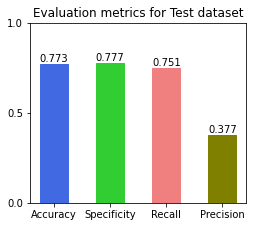

In [28]:
test_plot(accuracy_score(y_test,y_pred_SMOTE),specificity_scorer(y_test,y_pred_SMOTE),recall_score(y_test,y_pred_SMOTE),precision_score(y_test,y_pred_SMOTE), 'SMOTE_test_dataset')

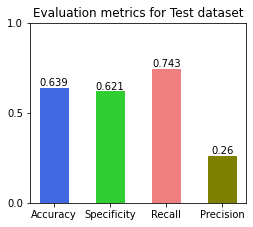

In [29]:
test_plot(accuracy_score(y_test,y_pred_CC),specificity_scorer(y_test,y_pred_CC),recall_score(y_test,y_pred_CC),precision_score(y_test,y_pred_CC), 'Cluster_Centroid_test_dataset')

In [78]:
def time_val(grid_search):
    mean_test_time = list(grid_search.cv_results_['mean_score_time'])
    mean_fit_time = list(grid_search.cv_results_['mean_fit_time'])
    sum_list = [a + b for a, b in zip(mean_test_time, mean_fit_time)]
    metric_l = ['euclidean', 'euclidean', 'euclidean', 'euclidean',
                       'euclidean', 'euclidean', 'manhattan', 'manhattan',
                       'manhattan', 'manhattan', 'manhattan', 'manhattan',
                       'chebyshev', 'chebyshev', 'chebyshev', 'chebyshev',
                       'chebyshev', 'chebyshev', 'minkowski', 'minkowski',
                       'minkowski', 'minkowski', 'minkowski', 'minkowski']
    k_l = [1, 3, 5, 9, 15, 25, 1, 3, 5, 9, 15, 25, 1, 3, 5, 9, 15,
                        25, 1, 3, 5, 9, 15, 25]
    time = defaultdict(dict)
    for k,v1,v2 in zip(metric_l, k_l, sum_list):
        time[k +' '+ str(v1)] = v2
    time = dict(time)
    return time
def plotting_time(grid_search1, grid_search2, grid_search3, grid_search4, grid_search5, name):
    
    metric_l = ['euclidean', 'euclidean', 'euclidean', 'euclidean',
                       'euclidean', 'euclidean', 'manhattan', 'manhattan',
                       'manhattan', 'manhattan', 'manhattan', 'manhattan',
                       'chebyshev', 'chebyshev', 'chebyshev', 'chebyshev',
                       'chebyshev', 'chebyshev', 'minkowski', 'minkowski',
                       'minkowski', 'minkowski', 'minkowski', 'minkowski']
    k_l = [1, 3, 5, 9, 15, 25, 1, 3, 5, 9, 15, 25, 1, 3, 5, 9, 15,
                        25, 1, 3, 5, 9, 15, 25]
    
    K = [1,3,5,9,15,25]

    metricss = ["euclidean", "manhattan", "chebyshev", "minkowski"]
    time1 = time_val(grid_search1)
    time2 = time_val(grid_search2)
    time3 = time_val(grid_search3)
    time4 = time_val(grid_search4)
    time5 = time_val(grid_search5)
    for j in metricss:
        fig, ax = plt.subplots(figsize=(10, 7))
        key_time1 = [s for s in time1 if j in s]
        key_time2 = [s for s in time2 if j in s]
        key_time3 = [s for s in time3 if j in s]
        key_time4 = [s for s in time4 if j in s]
        key_time5 = [s for s in time5 if j in s]
        
        r1 = np.arange(len([time1[s] for s in key_time1]))
        r2 = [x + 1.3 * barWidth for x in r1]
        r3 = [x + 1.3 * barWidth for x in r2]
        r4 = [x + 1.3 * barWidth for x in r3]
        r5 = [x + 1.3 * barWidth for x in r4]
        
        # Make the plot
        rects1 = ax.bar(r1, [time1[s] for s in key_time1], color='royalblue', width=barWidth, edgecolor='darkblue', label='Random under-sampling', align='edge')
        rects2 = ax.bar(r2, [time2[s] for s in key_time2], color='red', width=barWidth, edgecolor='darkblue', label='Bootstrap over-sampling', align='edge')
        rects3 = ax.bar(r3, [time3[s] for s in key_time3], color='green', width=barWidth, edgecolor='darkblue', label='SMOTE', align='edge')
        rects4 = ax.bar(r4, [time4[s] for s in key_time4], color='yellow', width=barWidth, edgecolor='darkblue', label='No resampling', align='edge')
        rects5 = ax.bar(r5, [time5[s] for s in key_time5], color='purple', width=barWidth, edgecolor='darkblue', label='Cluster Centroid', align='edge')





        # Add xticks on the middle of the group bars
        ax.set_xlabel('Factor k', fontweight='bold')
        #ax.set_xticks([r + barWidth for r in range(len(acc))], K)
        #ax.set_yticks(np.arange(0, 1.25, 0.5))
        ax.set_yticks(np.arange(0, 1500, 200))
        
        ax.set_xticks(r1 + 3 * barWidth)
        ax.set_xticklabels((K))



        def autolabel(rects, xpos='center'):
            """
            Attach a text label above each bar in *rects*, displaying its height.

            *xpos* indicates which side to place the text w.r.t. the center of
            the bar. It can be one of the following {'center', 'right', 'left'}.
            """

            ha = {'center': 'center', 'right': 'left', 'left': 'right'}
            offset = {'center': 0, 'right': 1, 'left': -1}

            for rect in rects:
                rect.set_linewidth(1.5)
                height = rect.get_height()
                ax.annotate('{}'.format(round(height,1)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(offset[xpos]*3, 3),  # use 3 points offset
                            textcoords="offset points",  # in both directions
                            ha=ha[xpos], va='bottom',rotation='vertical')


        autolabel(rects1, "center")
        autolabel(rects2, "center")
        autolabel(rects3, "center")
        autolabel(rects4, "center")
        autolabel(rects5, "center")
        



        # Create legend & Show graphic
        #plt.legend()
        plt.title(name+j, fontsize=15)
        ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
        fig.savefig(name+j, facecolor='w', bbox_inches='tight')
        
        





In [14]:
grid_search_RUS.cv_results_

{'mean_fit_time': array([0.04862888, 0.05488727, 0.05496299, 0.05380893, 0.05487289,
        0.05824516, 0.04860203, 0.04794338, 0.05506933, 0.05169735,
        0.05063591, 0.0504693 , 0.05113919, 0.05360482, 0.05148389,
        0.05119381, 0.05666981, 0.0555964 , 0.05627582, 0.05293493,
        0.05423462, 0.05434637, 0.05551105, 0.05561528]),
 'std_fit_time': array([0.00965675, 0.01052182, 0.00458497, 0.00673492, 0.00474666,
        0.00747232, 0.00353222, 0.00261076, 0.00395791, 0.00338804,
        0.00189377, 0.00269625, 0.00310134, 0.00263964, 0.00296115,
        0.00320924, 0.00568945, 0.00664314, 0.00730445, 0.00572812,
        0.002904  , 0.00381378, 0.00358279, 0.01339871]),
 'mean_score_time': array([ 2.73634455,  2.14537737,  2.26257966,  2.1288027 ,  2.43100786,
         2.4557492 ,  5.51034544,  5.6012768 ,  6.22529035,  6.05574043,
         6.34462886,  6.05653548,  5.5665041 ,  5.79989169,  6.30249741,
         6.08253   ,  6.2218271 ,  6.29106398, 92.49156678, 93.972058

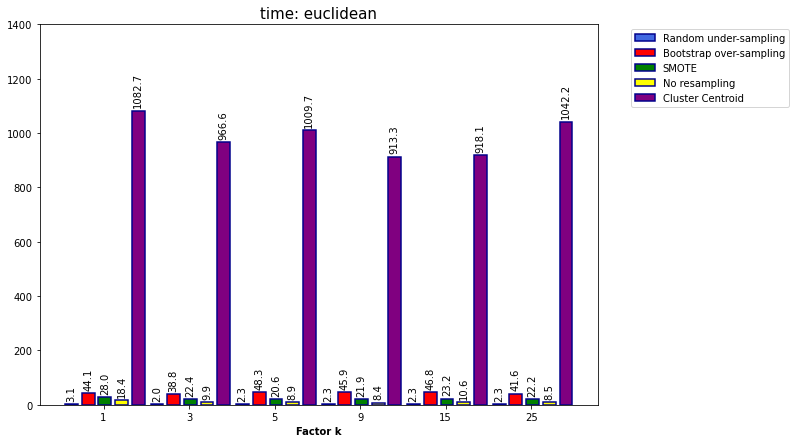

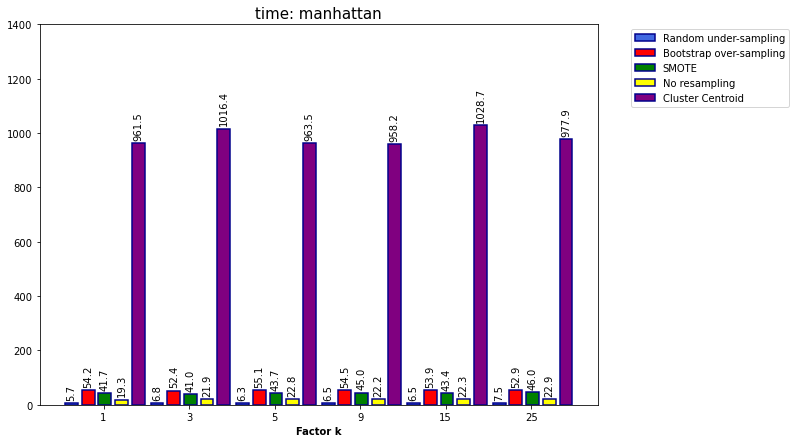

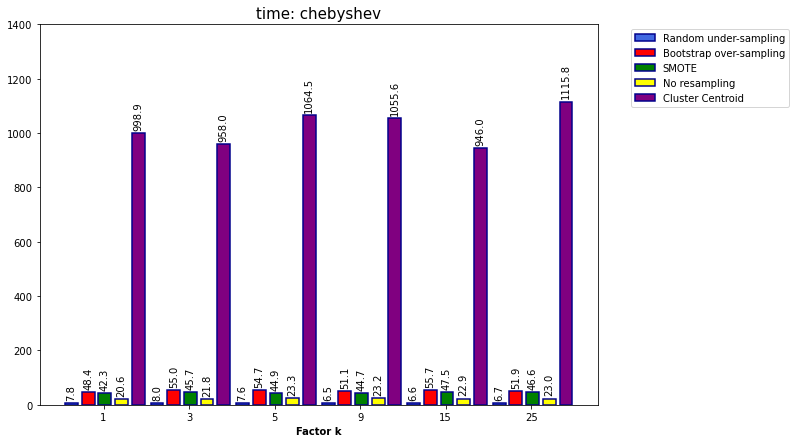

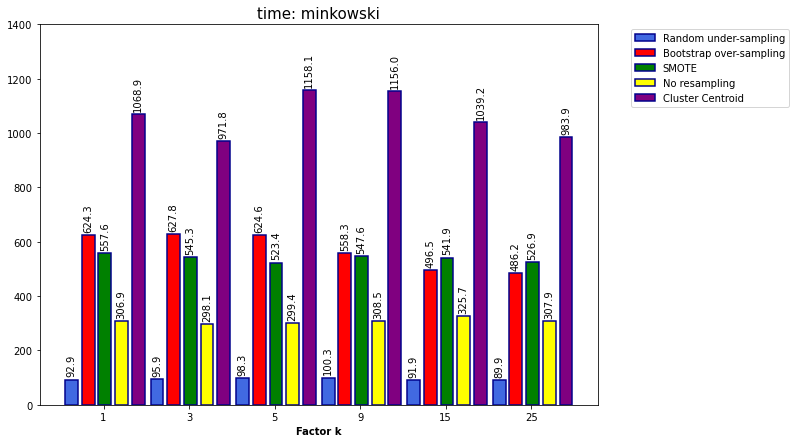

In [79]:
plotting_time(grid_search_RUS,grid_search_boot,grid_search_SMOTE, grid_search_No_Res, grid_search_CC, "time: ")